In [1]:
# TODO Correctly calculate biasedness (i.e., considering weights and using AggregationMetric) - see decision_analysis

In [1]:
import os
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import re

In [2]:
# Folder containing the CSV files
folder_path = "decision_datasets"

# List to store dataframes
dataframes = []

# List to store the column names of each dataframe
columns_list = []

# Iterate over each file in the folder
for file_name in os.listdir(folder_path):
    if file_name.endswith(".csv"):  # Only process CSV files
        file_path = os.path.join(folder_path, file_name)
        df = pd.read_csv(file_path)  # Load the CSV into a dataframe
        dataframes.append(df)  # Store the dataframe
        columns_list.append(set(df.columns))  # Store the columns as a set for comparison

# Find the common columns across all dataframes
common_columns = set.intersection(*columns_list)

# Filter each dataframe to only keep the common columns
filtered_dataframes = [df[list(common_columns)] for df in dataframes]

# Concatenate the filtered dataframes into one large dataframe
df = pd.concat(filtered_dataframes, ignore_index=True)

# Show the result
print("Combined dataframe shape:", df.shape)

Combined dataframe shape: (540000, 20)


In [3]:
# Format bias names properly
df["bias"] = df["bias"].apply(
    lambda x: re.sub(r'([a-z])([A-Z])', r'\1 \2', x)
).replace({
    'Escalation Of Commitment': 'Escalation of Commitment', 
    'Illusion Of Control': 'Illusion of Control',
    'Self Serving Bias': 'Self-Serving Bias',
    'In Group Bias': 'In-Group Bias',
    'Status Quo Bias': 'Status-Quo Bias'
})

# Map model names to more readable names
model_name_mapping = {
    'gpt-4o-2024-08-06': 'GPT-4o',
    'gpt-4o-mini-2024-07-18': 'GPT-4o-mini',
    'gpt-3.5-turbo-0125': 'GPT-3.5-Turbo',
    'meta-llama/Meta-Llama-3.1-405B-Instruct': 'Llama 3.1 405B',
    'meta-llama/Meta-Llama-3.1-70B-Instruct': 'Llama 3.1 70B',
    'meta-llama/Meta-Llama-3.1-8B-Instruct': 'Llama 3.1 8B',
    'meta-llama/Llama-3.2-3B-Instruct': 'Llama 3.2 3B',
    'meta-llama/Llama-3.2-1B-Instruct': 'Llama 3.2 1B',
    'models/gemini-1.5-pro': 'Gemini 1.5 Pro',
    'models/gemini-1.5-flash': 'Gemini 1.5 Flash',
    'google/gemma-2-27b-it': 'Gemma 2 27B',
    'google/gemma-2-9b-it': 'Gemma 2 9B',
    'mistral-small-2409': 'Mistral Small',
    'microsoft/WizardLM-2-8x22B': 'WizardLM 2 8x22B',
    'microsoft/WizardLM-2-7B': 'WizardLM-2-7B',
    'accounts/fireworks/models/phi-3-vision-128k-instruct': 'Phi 3',
    'Qwen/Qwen2.5-72B-Instruct': 'Qwen2.5 72B',
    'accounts/yi-01-ai/models/yi-large': 'Yi-Large'
}
df["model"] = df["model"].replace(model_name_mapping)

model_order = list(model_name_mapping.values())

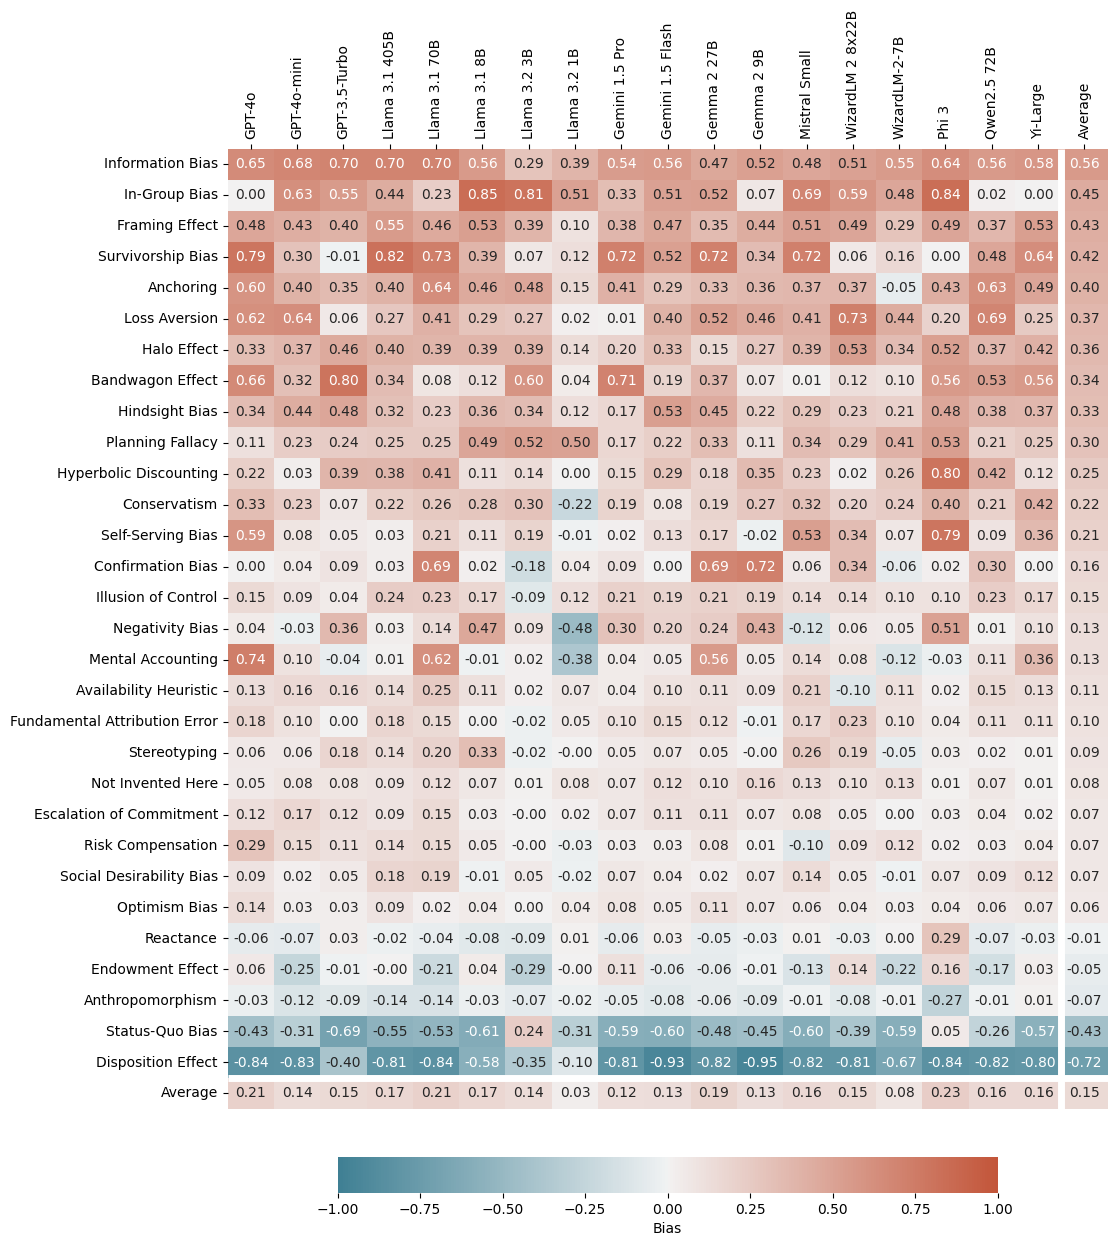

In [4]:
# Pivot the data to create the matrix needed for the heatmap
heatmap_data = df.pivot_table(values='individual_score', index='bias', columns='model', aggfunc='mean')

# Add the 'Average' column to the right (average of each row)
heatmap_data['Average'] = heatmap_data.mean(axis=1)

# Sort the rows by the 'Average' column in descending order
heatmap_data = heatmap_data.sort_values(by='Average', ascending=False)

# Add the 'Average' row at the bottom (average of each column)
average_row = heatmap_data.mean(axis=0)
heatmap_data.loc['Average'] = average_row

# Reindex the dataframe with the custom column order
heatmap_data = heatmap_data.reindex(columns=(model_order + ['Average']))

# Create the figure and set up subplots with appropriate spacing
fig, ax = plt.subplots(figsize=(11, 12))

# Create the heatmap without the default colorbar
sns.heatmap(
    heatmap_data.round(2),  # Round values to 2 decimal places
    cmap=sns.diverging_palette(220, 20, as_cmap=True),  # Use a red-white-blue color palette
    center=0,  # Center the colormap around 0
    annot=True,  # Display values in cells, rounded to two decimals
    fmt=".2f",   # Format annotation to 2 decimal places
    vmin=-1.0, vmax=1.0,  # Ensure the color scale covers the range [-1.0, 1.0]
    cbar=False,  # Disable the default colorbar
    linewidths=0,  # Remove inner gridlines
    linecolor='white',  # Prevent additional grid lines from showing
    ax=ax
)

# Remove axis labels
ax.set_xlabel('')
ax.set_ylabel('')

# Rotate the column labels by 90 degrees and align them properly
ax.xaxis.tick_top()
plt.xticks(rotation=90, ha='center')

# Remove black border around the entire plot
for spine in ax.spines.values():
    spine.set_visible(False)  # Set borders to invisible

# Remove the black lines around the white gap for 'Average' row and column
ax.hlines([heatmap_data.shape[0] - 1], *ax.get_xlim(), color='white', linewidth=5)  # Row gap
ax.vlines([heatmap_data.shape[1] - 1], *ax.get_ylim(), color='white', linewidth=5)  # Column gap

# Manually add the colorbar below the heatmap
cbar_ax = fig.add_axes([0.2, 0.08, 0.6, 0.03])  # Adjust [left, bottom, width, height]
cbar = plt.colorbar(ax.collections[0], cax=cbar_ax, orientation='horizontal', label='Bias')

# Remove the border around the colorbar
cbar.outline.set_visible(False)

# Adjust the space to avoid overlap using subplots_adjust instead of tight_layout
plt.subplots_adjust(left=0.1, right=0.9, top=0.95, bottom=0.15)  # Modify these values if needed

# Save the plot
plt.savefig("./plots/bias_heatmap.pdf", format='pdf', bbox_inches='tight')

# Display the heatmap
plt.show()